# **Introduction to Reinforcement Learning with Taxi V2 OpenAI Gym**

We shall use the Taxi V2 Open AI gym library. 
The Documentation can be found at: https://github.com/openai/gym/blob/master/gym/envs/toy_text/taxi.py

In [1]:
import gym # openAi gym
from gym import envs
import numpy as np 
import datetime
import keras 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pandas as pd 
from time import sleep

from rl.agents.dqn import DQNAgent
from rl.policy import LinearAnnealedPolicy, BoltzmannQPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
from rl.core import Processor
from rl.callbacks import FileLogger, ModelIntervalCheckpoint

Using TensorFlow backend.


# **1. Intro to taxi game environment**

The aim of the taxi game is to make sure the taxi can get to the passenger, pick him up and bring him to the drop-off location in the fastest way possible.

**Representations**

- | --> WALL (Can't pass through, will remain in the same position if tries to move through wall)

- Yellow --> Taxi Current Location

- Blue --> Pick up Location

- Purple --> Drop-off Location

- Green --> Taxi turn green once passenger board

- Letters --> Locations


In [2]:
env = gym.make('Taxi-v2')
env.reset()
env.render()

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



Total Number of states in the environment = **500** (0 to 499)

In [3]:
env.observation_space.n   #Total no. of states

500

**Actions (6 in total)**

- 0: move south
- 1: move north
- 2: move east 
- 3: move west 
- 4: pickup passenger
- 5: dropoff passenger

In [4]:
env.action_space.n   #Total no. of actions

6

In [5]:
env.env.s = 122
env.render()

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [6]:
env.step(3)

(102, -1, False, {'prob': 1.0})

Each timestep, the agent chooses an action, and the environment returns an observation and a reward.

The 4 elements returned are:

-  **Observation (object)**: the state the environment is in or an environment-specific object representing your observation of the environment.
-  **Reward (float)**: Reward achieved by the previous action. 
    -  +20: Last step when we successfully pick up a passenger and drop them off at their desired location
    -  -1: for each step in order for the agent to try and find the quickest solution possible
    -  -10: every time you incorrectly pick up or drop off a passenger
-  **Done (boolean)**: whether it’s time to reset the environment again. Most (but not all) tasks are divided up into well-defined episodes, and done being True indicates the episode has terminated. (For example, you lost your last life.)
-  **Info (dict)**: Can be ignored, diagnostic information useful for debugging. Official evaluations of your agent are not allowed to use this for learning.

In [7]:
env.render()  #view state

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)


The function (env.P) below can be used to see the relevant states and rewards for each action taken in that particular state.

In [8]:
env.reset()
env.env.P[300]

{0: [(1.0, 400, -1, False)],
 1: [(1.0, 200, -1, False)],
 2: [(1.0, 300, -1, False)],
 3: [(1.0, 300, -1, False)],
 4: [(1.0, 300, -10, False)],
 5: [(1.0, 300, -10, False)]}

# **2. Random Search**
Let's start with the simplest way to train our agent to complete this task. The agent would just take random steps at every state until he completes the task (picking the passenger and dropping him off at the drop-off location). 

In [9]:
env = gym.make('Taxi-v2')
random_policy = np.ones([env.env.nS, env.env.nA]) / env.env.nA
def random_policy_steps_count():
    state = env.reset()
    counter = 0
    reward = None
    while reward != 20:
        state, reward, done, info = env.step(env.action_space.sample())  
        counter += 1
    return counter


/home/angps/anaconda3/envs/angps/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Distribution of number of steps needed')

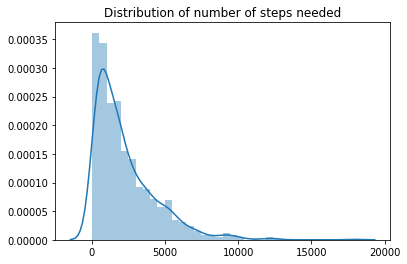

In [10]:
counts = [random_policy_steps_count() for i in range(1000)]
sns.distplot(counts)
plt.title("Distribution of number of steps needed")

In [11]:
print("An agent using Random search takes about an average of " + str(int(np.mean(counts)))
      + " steps to successfully complete its mission.")

An agent using Random search takes about an average of 2263 steps to successfully complete its mission.


Clearly, it is not the most efficient way to complete this. Let's try to use policy iteration and value iteration method to more effectively let our agent complete this task. 

# **3. Policy Iteration/Value Iteration**

**Policy Iteration** --> The algorithm redefines the policy at each step and improve the policy, and then compute the value according to this new policy until the policy converges.

**Value Iteration** --> The algorithm computes the optimal state value function by iteratively improving the estimate of V(s). The algorithm initialize V(s) to arbitrary random values. It repeatedly updates the Q(s, a) and V(s) values until they converge. 


Policy iteration and Value Iteration are guranteed to convege to the optimal policy and it often takes less iterations for policy iteration to converge than the value-iteration algorithm.

Both value-iteration and policy-iteration algorithms can be used for offline planning where the agent is assumed to have prior knowledge about the effects of its actions on the environment (they assume the Markov Decision model is known). Comparing to each other, policy-iteration is computationally efficient as it often takes considerably fewer number of iterations to converge although each iteration is more computationally expensive.

**3.1 Functions for policy evaluation, policy iteration and value iteration.**

In [12]:
def policy_eval(policy, env, discount_factor=1.0, theta=0.00001):
    """
    Evaluate a policy given an environment and a full description of the environment's dynamics.
    
    Args:
        policy: [S, A] shaped matrix representing the policy.
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment. 
            env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: Gamma discount factor.
    
    Returns:
        Vector of length env.nS representing the value function.
    """
    # Start with a random (all 0) value function
    V = np.zeros(env.env.nS)
    while True:
        # TODO: Implement!
        delta = 0  #delta = change in value of state from one iteration to next
       
        for state in range(env.env.nS):  #for all states
            val = 0  #initiate value as 0
            
            for action,act_prob in enumerate(policy[state]): #for all actions/action probabilities
                for prob,next_state,reward,done in env.env.P[state][action]:  #transition probabilities,state,rewards of each action
                    val += act_prob * prob * (reward + discount_factor * V[next_state])  #eqn to calculate
            delta = max(delta, np.abs(val-V[state]))
            V[state] = val
        if delta < theta:  #break if the change in value is less than the threshold (theta)
            break
    return np.array(V)

def policy_iteration(env, policy_eval_fn=policy_eval, discount_factor=1.0):
    """
    Policy Improvement Algorithm. Iteratively evaluates and improves a policy
    until an optimal policy is found.
    
    Args:
        env: The OpenAI envrionment.
        policy_eval_fn: Policy Evaluation function that takes 3 arguments:
            policy, env, discount_factor.
        discount_factor: gamma discount factor.
        
    Returns:
        A tuple (policy, V). 
        policy is the optimal policy, a matrix of shape [S, A] where each state s
        contains a valid probability distribution over actions.
        V is the value function for the optimal policy.
        
    """
    def one_step_lookahead(state, V):
        """
        Helper function to calculate the value for all action in a given state.
        
        Args:
            state: The state to consider (int)
            V: The value to use as an estimator, Vector of length env.nS
        
        Returns:
            A vector of length env.nA containing the expected value of each action.
        """
        A = np.zeros(env.env.nA)
        for a in range(env.env.nA):
            for prob, next_state, reward, done in env.env.P[state][a]:
                A[a] += prob * (reward + discount_factor * V[next_state])
        return A
    # Start with a random policy
    policy = np.ones([env.env.nS, env.env.nA]) / env.env.nA

    while True:
        # Implement this!
        curr_pol_val = policy_eval_fn(policy, env, discount_factor)  #eval current policy
        policy_stable = True  #Check if policy did improve (Set it as True first)
        for state in range(env.env.nS):  #for each states
            chosen_act = np.argmax(policy[state])  #best action (Highest prob) under current policy
            act_values = one_step_lookahead(state,curr_pol_val)  #use one step lookahead to find action values
            best_act = np.argmax(act_values) #find best action
            if chosen_act != best_act:
                policy_stable = False  #Greedily find best action
            policy[state] = np.eye(env.env.nA)[best_act]  #update 
        if policy_stable:
            return policy, curr_pol_val
    
    return policy, np.zeros(env.env.nS)

def value_iteration(env, theta=0.0001, discount_factor=1.0):
    """
    Value Iteration Algorithm.
    
    Args:
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment. 
            env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: Gamma discount factor.
        
    Returns:
        A tuple (policy, V) of the optimal policy and the optimal value function.        
    """
    
    def one_step_lookahead(state, V):
        """
        Helper function to calculate the value for all action in a given state.
        
        Args:
            state: The state to consider (int)
            V: The value to use as an estimator, Vector of length env.nS
        
        Returns:
            A vector of length env.nA containing the expected value of each action.
        """
        A = np.zeros(env.env.nA)
        for act in range(env.env.nA):
            for prob, next_state, reward, done in env.env.P[state][act]:
                A[act] += prob * (reward + discount_factor*V[next_state])
        return A
    
    V = np.zeros(env.env.nS)
    while True:
        delta = 0  #checker for improvements across states
        for state in range(env.env.nS):
            act_values = one_step_lookahead(state,V)  #lookahead one step
            best_act_value = np.max(act_values) #get best action value
            delta = max(delta,np.abs(best_act_value - V[state]))  #find max delta across all states
            V[state] = best_act_value  #update value to best action value
        if delta < theta:  #if max improvement less than threshold
            break
    policy = np.zeros([env.env.nS, env.env.nA])
    for state in range(env.env.nS):  #for all states, create deterministic policy
        act_val = one_step_lookahead(state,V)
        best_action = np.argmax(act_val)
        policy[state][best_action] = 1
        
    
    # Implement!
    return policy, V

Let's evaluate the random policy. 

In [13]:
env = gym.make('Taxi-v2')
random_policy = np.ones([env.env.nS, env.env.nA]) / env.env.nA
policy_eval(random_policy,env,discount_factor=0.95)

array([-64.52483596, -71.98303998, -71.59548842, -72.0983153 ,
       -79.64362433, -79.32480882, -79.64974547, -79.63131331,
       -79.05557089, -79.10000212, -77.9706677 , -79.10335244,
       -79.81584076, -79.80701521, -79.81712685, -79.63332039,
       -54.13993621, -71.16899479, -70.28411232, -71.43219898,
       -71.25030023, -75.46716562, -75.24804402, -75.53234223,
       -79.57512987, -79.19501136, -79.582428  , -79.56045159,
       -79.21609557, -79.25297406, -78.31561183, -79.25575487,
       -79.7862176 , -79.77597107, -79.78771075, -79.57431099,
       -64.88302165, -74.00606431, -73.45166685, -74.40668129,
       -78.74777188, -79.3512305 , -79.3198729 , -79.36055765,
       -77.8651867 , -75.95477715, -77.90186579, -77.79141546,
       -79.71322567, -79.72671362, -79.38388062, -79.72773067,
       -79.47239266, -79.44709493, -79.47607904, -78.94922067,
       -75.48283869, -72.17301644, -76.28261086, -75.78218888,
       -79.10235711, -79.53492541, -79.51244783, -79.54

Now let's use policy iteration to improve our policy. 

In [14]:
pol_iter_policy = policy_iteration(env,policy_eval,discount_factor=0.99)
pol_iter_policy

(array([[0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0.],
        ...,
        [0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.]]),
 array([1978.99901398, 1857.33625444, 1897.07811877, 1837.76287228,
        1742.79321998, 1857.33625444, 1706.12160705, 1761.4072642 ,
        1818.38527255, 1742.79320113, 1897.07811877, 1761.4072642 ,
        1706.12162571, 1742.79320113, 1706.12160705, 1837.76287228,
        1999.99901398, 1877.10733758, 1917.25063498, 1857.33624458,
        1958.20902384, 1837.7628919 , 1877.10733758, 1818.38524355,
        1761.40730228, 1877.10733758, 1724.36526912, 1780.20936754,
        1799.20141982, 1724.36526912, 1877.10733758, 1742.79319156,
        1724.36528778, 1761.40728344, 1724.36526912, 1857.33624458,
        1978.99902384, 1897.07812863, 1897.07812863, 1877.10732772,
        1897.07814805, 1780.20938678, 1818.38526298, 1761.40727387,
        1818.38528202, 1937.62691

Next, we use value iteration to improve our policy.

In [15]:
val_iter_policy = value_iteration(env,discount_factor=0.99)
val_iter_policy

(array([[0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0.],
        ...,
        [0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.]]),
 array([1978.99015022, 1857.32747932, 1897.06925501, 1837.75400852,
        1742.78487492, 1857.32747932, 1706.1131777 , 1761.39857683,
        1818.37675805, 1742.78468664, 1897.06925501, 1761.39857683,
        1706.11336411, 1742.78468664, 1706.1131777 , 1837.75400852,
        1999.99015022, 1877.09856246, 1917.24177122, 1857.32738082,
        1958.20024872, 1837.75420453, 1877.09856246, 1818.37646843,
        1761.39895723, 1877.09856246, 1724.35683977, 1780.20068017,
        1799.19299047, 1724.35683977, 1877.09856246, 1742.78459106,
        1724.35702617, 1761.39876894, 1724.35683977, 1857.32738082,
        1978.99024872, 1897.06935351, 1897.06935351, 1877.09846396,
        1897.06954756, 1780.20087228, 1818.37666248, 1761.39867337,
        1818.37685267, 1937.61805

In [16]:
for x in range(len(pol_iter_policy[0])):
    if not (pol_iter_policy[0][x] == val_iter_policy[0][x]).all():
        print("Not the same Policy")
        break
print("Same Policy")

Same Policy


We can see that policy-iterated and value-iterated policies would converge to the same policy. 

In [17]:
def count(policy):
    curr_state = env.reset()
    counter = 0
    reward = None
    while reward != 20:
        state, reward, done, info = env.step(np.argmax(policy[curr_state]))  
        curr_state = state
        counter += 1
    return counter

In [18]:
optimal_counts = count(pol_iter_policy[0])
print("An agent using a policy which has been improved using policy-iterated takes about an average of " + str(int(np.mean(optimal_counts)))
      + " steps to successfully complete its mission.")

An agent using a policy which has been improved using policy-iterated takes about an average of 7 steps to successfully complete its mission.


In [19]:
optimal_counts1 = count(val_iter_policy[0])
print("An agent using a policy which has been value-iterated takes about an average of " + str(int(np.mean(optimal_counts1)))
      + " steps to successfully complete its mission.")

An agent using a policy which has been value-iterated takes about an average of 10 steps to successfully complete its mission.


**We can see that the improved policy is definitely much more efficient than the random search.**

# **4. Now, let's implement Q-learning** 

The algorithm for Q-learning is as follows:

- Initialize the Q-table by all zeros.
- Start exploring actions: For each state, select any one among all possible actions for the current state (S).
- Travel to the next state (S') as a result of that action (a).
- For all possible actions from the state (S') select the one with the highest Q-value.
- Update Q-table values using the equation:  **Q(state,action) <- (1−α) * Q(state,action) + α(reward + γ * max<sub>a</sub>Q(next state,all actions))**
- Set the next state as the current state.
- If goal state is reached, then end and repeat the process.

# **5. Let's watch how both our optimal policy works in action**

In [20]:
def view_policy(policy):
    curr_state = env.reset()
    counter = 0
    reward = None
    while reward != 20:
        state, reward, done, info = env.step(np.argmax(policy[0][curr_state])) 
        curr_state = state
        counter += 1
        env.env.s = curr_state
        env.render()
    

In [21]:
view_policy(pol_iter_policy)

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
+---------+
|R: | : :G|
|_: : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : : : : |
|_: : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : : : : |
| :_: : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : : : : |
| : :_: : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : : : : |
| : : :_: |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : |_: |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y|

In [22]:
view_policy(val_iter_policy)

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B:_|
+---------+
  (East)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | :_|
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : : : : |
| : : : :_|
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : : : :_|
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)


We can also view it animated by running the function below. 

In [77]:
from IPython.display import clear_output
from time import sleep

import matplotlib.pyplot as plt
%matplotlib inline

# Imports specifically so we can render outputs in Jupyter.
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display


def view_policy_anim(policy):
    penalties, reward = 0, 0

    frames = [] # for animation

    done = False
    curr_state = env.reset()
    while not done:
        action = np.argmax(policy[0][curr_state])
        state, reward, done, info = env.step(action)
        curr_state = state
        if reward == -10:
            penalties += 1

        # Put each rendered frame into dict for animation
        frames.append({
            'frame': env.render(mode='ansi'),
            'state': state,
            'action': action,
            'reward': reward
            }
        )
    def print_frames(frames):
        for i, frame in enumerate(frames):
            clear_output(wait=True)
            print(frame['frame'].getvalue())
            print(f"Timestep: {i + 1}")
            print(f"State: {frame['state']}")
            print(f"Action: {frame['action']}")
            print(f"Reward: {frame['reward']}")
            sleep(.2)

    print_frames(frames)

In [82]:
view_policy_anim(val_iter_policy)

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Timestep: 11
State: 97
Action: 5
Reward: 20


In [76]:
view_policy_anim(pol_iter_policy)

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Timestep: 14
State: 97
Action: 5
Reward: 20
